In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

地理院市区町村界データを取得し、片品村をプロット

In [ ]:
gdf = gpd.read_file("N03-20250101_10.geojson")

In [3]:
katashina = gdf[gdf["N03_004"] == "片品村"]

Text(0.5, 1.0, 'area of Katashina village')

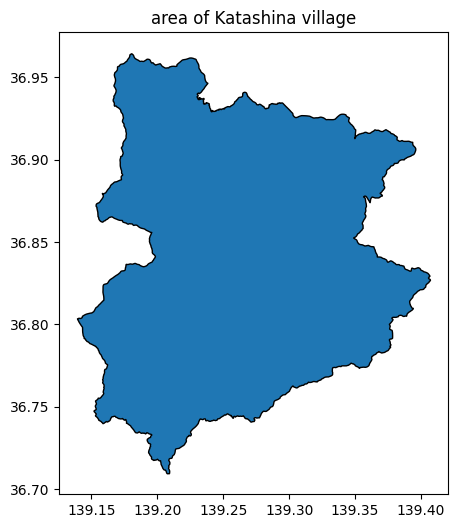

In [4]:
katashina.plot(edgecolor="black", figsize=(6,6))
plt.title("area of Katashina village")

片品村の重心を計算

In [ ]:
katashina_proj = katashina.to_crs(epsg=3099)  # EPSG: 3099 is UTM zone 53N for Japan 東経132-138
centroid = katashina_proj.geometry.centroid
bbox = katashina_proj.total_bounds
xmin, ymin, xmax, ymax = bbox
xs = [xmin, xmax, xmax, xmin, xmin]
ys = [ymin, ymin, ymax, ymax, ymin]

[centroid, xmin, ymin, xmax, ymax, xs, ys]  # Show centroid and bounding box coordinates EPSG:3099 なので、単位はメートル

[27    POINT (879989.869 4085776.143)
 dtype: geometry,
 np.float64(869317.0819975062),
 np.float64(4070919.624911456),
 np.float64(893087.8380743087),
 np.float64(4099109.9587783637),
 [np.float64(869317.0819975062),
  np.float64(893087.8380743087),
  np.float64(893087.8380743087),
  np.float64(869317.0819975062),
  np.float64(869317.0819975062)],
 [np.float64(4070919.624911456),
  np.float64(4070919.624911456),
  np.float64(4099109.9587783637),
  np.float64(4099109.9587783637),
  np.float64(4070919.624911456)]]

グラフ描画

Text(0.5, 1.0, 'Katashina village: centroid and bounding box')

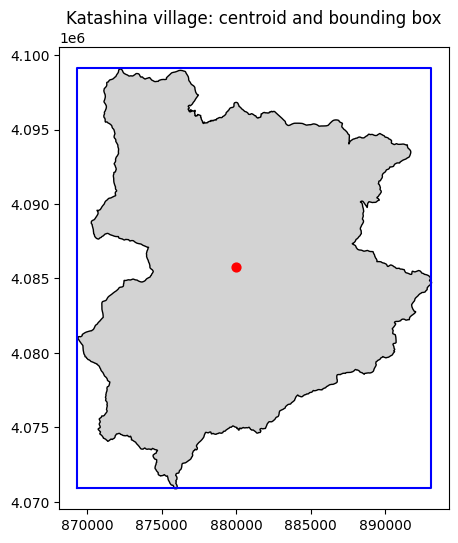

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
katashina_proj.plot(ax=ax, color="lightgray", edgecolor="black")
centroid.plot(ax=ax, color="red", markersize=40)

ax.plot(xs, ys, color="blue")
plt.title("Katashina village: centroid and bounding box")


## 片品村のDEMタイルを地理院から取得

まずは緯度経度範囲を取得

In [7]:
katashina.total_bounds

array([139.13910039,  36.70963233, 139.40670927,  36.96452192])

In [8]:
lon_min, lon_max = 139.13910039, 139.40670927
lat_min, lat_max = 36.70963233, 36.96452192

タイル座標に変換。
参考: https://maps.gsi.go.jp/development/siyou.html

In [37]:
import math

def lonlat_to_tile(lon, lat, z):
    lat_rad = math.radians(lat)
    n = 2 ** z
    x = int((lon + 180.0) / 360.0 * n)
    y = int((1 - math.log(math.tan(lat_rad) + 1/math.cos(lat_rad)) / math.pi) / 2 * n)
    return x, y

def tile_to_lonlat(x, y, z):
    n = 2 ** z
    lon = x / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * y / n)))
    lat = math.degrees(lat_rad)
    return lon, lat

今回はZ=14（DEM10B: 1/2.5万地形図等高線）の最大を採用
https://maps.gsi.go.jp/development/hyokochi.html

In [12]:
x_min, y_min = lonlat_to_tile(lon_min, lat_max, 14)  # (x_min, y_min)
x_min, y_min

(14524, 6379)

In [14]:
x_max, y_max = lonlat_to_tile(lon_max, lat_min, 14)  # (x_max, y_max)
x_max, y_max

(14536, 6393)

URL一覧を生成

In [17]:
urls = []
for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        urls.append(f"https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/{x}/{y}.png")
urls

['https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6379.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6380.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6381.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6382.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6383.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6384.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6385.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6386.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6387.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6388.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6389.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6390.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6391.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6392.png',
 'https://cyberjapandata.gsi.go.jp/xyz/dem_png/14/14524/6393.p

In [18]:
len(urls)

195

地理院のサイトからダウンロード

In [19]:
import requests

In [25]:
import time
from pathlib import Path

In [26]:
for url in urls:
    response = requests.get(
        url,
        headers={"User-Agent": "downloader by susumuis (for personal GIS research)"}
    )
    filename = url.split("/")[-3] + "_" + url.split("/")[-2] + "_" + url.split("/")[-1]
    with open(Path("output") / filename, "wb") as f:
        f.write(response.content)
    time.sleep(0.1)

画像を結合

In [27]:
from pathlib import Path
from PIL import Image

In [28]:
tiles_dir = Path("output")
z = 14

どんな画像か確認

In [33]:
sample_path = tiles_dir / f"{z}_{x_min}_{y_min}.png"
sample_img = Image.open(sample_path)
tile_width, tile_height = sample_img.size
mode = sample_img.mode
print("tile size:", tile_width, tile_height, "mode:", mode)


tile size: 256 256 mode: RGB


全体のサイズを計算

In [34]:
nx = x_max - x_min + 1  # 横方向のタイル数
ny = y_max - y_min + 1  # 縦方向のタイル数

merged_width = nx * tile_width
merged_height = ny * tile_height

print("merged size:", merged_width, merged_height)

merged size: 3328 3840


画像を結合して保存

In [36]:
merged = Image.new(mode, (merged_width, merged_height))
# 上から下へ（y_min が最北 → 画像の一番上）
for j, y in enumerate(range(y_min, y_max + 1)):
    for i, x in enumerate(range(x_min, x_max + 1)):
        tile_path = tiles_dir / f"{z}_{x}_{y}.png"
        tile = Image.open(tile_path)

        # 貼り付け位置（左上座標）
        px = i * tile_width
        py = j * tile_height

        merged.paste(tile, (px, py))

# 保存
out_path = Path("katashina_dem_z14_merged.png")
merged.save(out_path)
print("saved:", out_path)

saved: katashina_dem_z14_merged.png


タイルXY番号を緯度経度に変換

In [38]:
# 左上タイル (x_min, y_min) の左上角
lon_ul, lat_ul = tile_to_lonlat(x_min, y_min, z)

# 右下タイル (x_max+1, y_max+1) の右下角
lon_lr, lat_lr = tile_to_lonlat(x_max + 1, y_max + 1, z)

print("upper-left:", lon_ul, lat_ul)
print("lower-right:", lon_lr, lat_lr)

upper-left: 139.130859375 36.96744946416932
lower-right: 139.41650390625 36.703659597194545


実行すべきコマンドラインを出力

In [45]:
print(rf"""gdal_translate \
  -of GTiff \
  -a_ullr {lon_ul} {lat_ul} {lon_lr} {lat_lr} \
  -a_srs EPSG:4326 \
  katashina_dem_z14_merged.png katashina_dem_z14_georef.tif
""")

gdal_translate \
  -of GTiff \
  -a_ullr 139.130859375 36.96744946416932 139.41650390625 36.703659597194545 \
  -a_srs EPSG:4326 \
  katashina_dem_z14_merged.png katashina_dem_z14_georef.tif



早速DEMを展開しよう

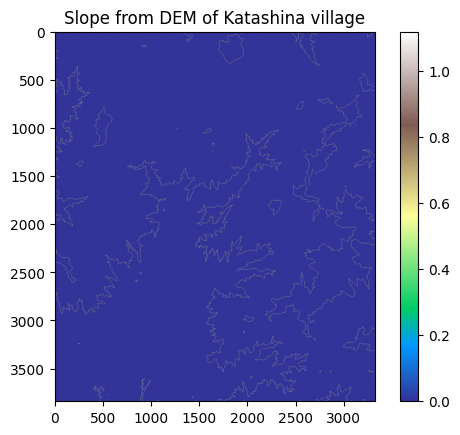

In [47]:
import rioxarray as rxr
import numpy as np

# 標高タイル（xyz形式）読み込み
dem = rxr.open_rasterio("output/katashina_dem_z14_georef.tif")

# 勾配計算
dy, dx = np.gradient(dem[0])
slope = np.sqrt(dx**2 + dy**2)

plt.imshow(slope, cmap="terrain")
plt.title("Slope from DEM of Katashina village")
plt.colorbar()
plt.show()